In [2]:
import numpy as np
import torch
import gym
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Use

In [21]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

writer = SummaryWriter()

In [22]:
# Actor module, categorical actions only
import math
leaky = torch.nn.LeakyReLU()

class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.n_actions = n_actions
        self.stds = torch.nn.Parameter(torch.Tensor([math.log(0.5)]*n_actions))
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_actions),
            nn.Tanh()
        )
        nn.init.kaiming_normal_(self.model[0].weight)
        nn.init.kaiming_normal_(self.model[2].weight)
        nn.init.kaiming_normal_(self.model[4].weight)
        
        # nn.init.kaiming_normal_(self.means_head[0].bias)
    
    def forward(self, X):
        means = self.model(X)
        dists = torch.distributions.Normal(means, torch.exp(self.stds))
        
        return dists

In [23]:
## Critic module
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
    
    def forward(self, X):
        return self.model(X)

In [24]:
env = gym.make("Pendulum-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/alvaro/.asdf/installs/python/3.6.3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [25]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3, weight_decay=0.001)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3, weight_decay=0.001)
gamma = 0.99
memory = []

In [26]:
def train(memory, next_value):
    values, logs_probs = [], []
    td_targets = np.zeros((len(memory), 1))
    
    for i, (log_probs, value, reward, done) in enumerate(memory[::-1]):
        logs_probs.insert(0, log_probs)
        values.insert(0, value)
        
        next_value = reward + gamma*next_value*(1.0-done)
        td_targets[len(memory)-1 - i] = next_value
    
    values = torch.stack(values)
    advantage = torch.Tensor(td_targets) - values
    
    critic_loss = advantage.pow(2).mean()
    adam_critic.zero_grad()
    critic_loss.backward()
    adam_critic.step()
    
    actor_loss = (-torch.stack(logs_probs)*advantage.detach()).mean()
    adam_actor.zero_grad()
    actor_loss.backward()
    adam_actor.step()
    
    writer.add_scalar("losses/critic", critic_loss.detach().data.numpy())
    writer.add_scalar("losses/actor", actor_loss.detach().data.numpy())

In [41]:
episode_rewards = []
total_steps = 0

for i in range(100):
    done = False
    total_reward = 0
    state = env.reset()
    max_steps = 500
    steps = 0

    while not done:
        dists = actor(t(state))
        actions = dists.sample()
        
        next_state, reward, done, info = env.step(actions.detach().data.numpy())
        # advantage = reward + (1-done)*gamma*critic(t(next_state)) - critic(t(state))
        
        memory.append((dists.log_prob(actions), critic(t(state)), reward, done))
        
        total_reward += reward
        state = next_state
        steps += 1
        total_steps += 1
        
        writer.add_scalar("dists/mean", dists.loc[0], global_step=total_steps)
        writer.add_scalar("dists/scale", dists.scale[0], global_step=total_steps)

        if done or (steps % max_steps == 0):
            next_value = critic(t(next_state)).detach().data.numpy()
            train(memory, next_value)
            memory.clear()
        
        # critic_loss = advantage.pow(2).mean()
        # adam_critic.zero_grad()
        # critic_loss.backward()
        # adam_critic.step()
# 
        # actor_loss = torch.sum(-dists.log_prob(actions)*advantage.detach())
        # adam_actor.zero_grad()
        # actor_loss.backward()
        # adam_actor.step()
        # env.render()
    
    writer.add_scalar("episode_reward", total_reward)
    episode_rewards.append(total_reward)

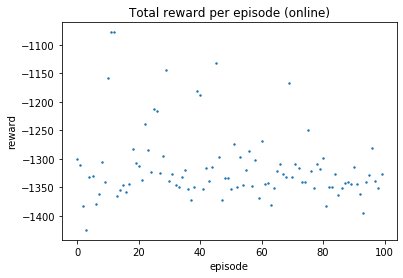

In [42]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (online)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

In [38]:
dists

Normal(loc: tensor([-0.9998], grad_fn=<TanhBackward>), scale: tensor([0.4997], grad_fn=<ExpBackward>))